<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Handwriting GAN

In [238]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import time
from PIL import Image, ImageOps
import gc
import pdb
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "drive/My Drive/datasets/iam.zip" "/content"

In [154]:
!unzip -q iam.zip
!rm iam.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [0]:
class IamDataset(Dataset):
  def __init__(self, label='category', img_size=64):
    if not os.path.exists('/content/labels.csv'):
      raise Exception('Iam dataset does not exist in /content/labels.csv')

    self.img_size = img_size
    self.path = '/content/images/'
    self.df = pd.read_csv('/content/labels.csv', sep='\t', header=None, names=['word', 'seg', 'transcription'])
    self.df = self.df.drop(['seg'], axis=1)

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    x = transforms.functional.to_tensor(img)

    # Look into automatically resizing or adding padding to images
    # With a GAN, we will likely need all the input images to be the same size

    return x

  def resize(self, img):
    old_size = img.size
    ratio = float(self.img_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = img.resize(new_size, Image.ANTIALIAS)

    new_img = Image.new("L", (self.img_size, self.img_size))
    new_img.paste(img, ((self.img_size - new_size[0]) // 2,
                        (self.img_size - new_size[1]) // 2))
    
    return new_img

  def __getitem__(self, index):
    img = self.tensor_image('images/' + self.df['word'][index])

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

In [0]:
def tensor_to_image(t):
  return transforms.ToPILImage()(t).convert("L")

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, conv=nn.Conv2d, stride=1, padding=1, kernel=3, activation=nn.LeakyReLU):
    super(ResidualBlock, self).__init__()

    self.conv1 = conv(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act1 = activation()
    self.conv2 = conv(out_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.act2 = activation()
    
    if in_channels != out_channels:
      self.needs_shortcut = True
      self.conv_short = conv(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride, bias=False)
      self.bn_short = nn.BatchNorm2d(out_channels)
      self.shortcut = nn.Sequential(
        self.conv_short,
        self.bn_short
      )
 
    else:
      self.needs_shortcut = False
  
  def forward(self, x):
    identity = x if not self.needs_shortcut else self.shortcut(x)
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.act1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.act2(out)

    if identity.shape[2] != out.shape[2]:
      identity = F.interpolate(identity, size=out.shape[2])

    out += identity

    return out

In [0]:
# helper function to initialize the weights using a normal distribution. 
# this was done in the original work (instead of xavier) and has been shown
# to help GAN performance
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [0]:
class Discriminator2(nn.Module):
  def __init__(self, img, layers=8, in_channels=1, channels=200):
    super(Discriminator, self).__init__()

    self.channels = channels
    self.height = img.shape[1]
    self.width = img.shape[2]

    layers = [ResidualBlock(channels, channels, conv=nn.Conv2d) for _ in range(layers)]
    layers.insert(0, ResidualBlock(in_channels, channels, conv=nn.Conv2d))
    self.blocks = nn.Sequential(*layers)

    self.fc = nn.Linear(self.channels * self.height * self.width, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.blocks(x)
    out = out.view(-1, self.channels * self.height * self.width)
    out = self.fc(out)
    out = self.sigmoid(out)
    return out.squeeze()

In [0]:
class Generator2(nn.Module):
  def __init__(self, img):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
      ResidualBlock(in_channels=100, out_channels=90, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=90, out_channels=80, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=80, out_channels=70, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=70, out_channels=60, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=60, out_channels=50, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=50, out_channels=40, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=40, out_channels=30, conv=nn.ConvTranspose2d, kernel=4, stride=1, padding=1),
      ResidualBlock(in_channels=30, out_channels=1, conv=nn.ConvTranspose2d, kernel=4, stride=2, padding=1)
    )

  def forward(self, x):
    return self.model(x)

In [0]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x.squeeze()

In [0]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

Label:  agitation


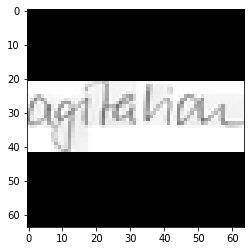

In [0]:
dataset = IamDataset()
item = dataset[5009]
img = item[0]
label = item[1]
imshow(tensor_to_image(img), cmap='gray')
print("Label: ", label)

In [0]:
def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [0]:
def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

In [0]:
def train():
  NUM_EPOCHS = 20
  BATCH_SIZE = 500
  RATIO = 2 # How many times will we train the generator for each time we train the discriminator
  IMG_ITERATIONS = 100 # Show example generator image after how many iterations

  dataset = IamDataset()

  generator = Generator()
  generator.weight_init(0, .02)
  generator = generator.cuda()

  discriminator = Discriminator()
  discriminator.weight_init(0, .02)
  discriminator = discriminator.cuda()

  print('\nGenerator: ', parameter_count(generator))
  print('Discriminator: ', parameter_count(discriminator))

  data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

  gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
  disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

  disc_objective = nn.BCELoss()
  gen_objective = nn.BCELoss()

  d_losses = []
  g_losses = []

  for epoch in range(NUM_EPOCHS):

    loop = tqdm(total=len(data_loader), position=0, leave=False)

    for batch, (real_images, real_transcriptions) in enumerate(data_loader):
      real_images = real_images.cuda(async=True)

      # Create labels for real/fake images
      fake_labels = torch.full((real_images.shape[0], 1), .1).squeeze().cuda()
      real_labels = torch.full((real_images.shape[0], 1), .9).squeeze().cuda()

      generator.zero_grad()
      discriminator.zero_grad()

      # Sample from latent vector
      z = torch.randn(real_images.shape[0], 100, 1, 1).cuda()
      fake_images = generator(z)
 
      # Train Generator

      gen_optimizer.zero_grad()

      fake_pred = discriminator(fake_images)
      gen_loss = gen_objective(fake_pred, real_labels) # The generator should be trying to generate real images

      g_losses.append(gen_loss.item())

      gen_loss.backward()
      gen_optimizer.step()

      # Train Discriminator
      if batch % RATIO == 0:
        disc_optimizer.zero_grad()

        fake_pred = discriminator(fake_images.detach()) # Detach so we aren't training the generator
        real_pred = discriminator(real_images)

        fake_loss = disc_objective(fake_pred, fake_labels)
        real_loss = disc_objective(real_pred, real_labels)
        disc_loss = 0.5 * (fake_loss + real_loss)

        d_losses.append(disc_loss.item())

        disc_loss.backward()
        disc_optimizer.step()
      
      if batch % IMG_ITERATIONS == 0:
        show_imgs(fake_images[:4])
        plt.pause(1)

      loop.set_description('Epoch: {}, Discriminator Loss: {:.4f}, Generator Loss: {:.4f}, AvgDiscriminator Loss: {:.4f}, AvgGenerator Loss: {:.4f}'.format(
          epoch, disc_loss.item(), gen_loss.item(), np.mean(d_losses), np.mean(g_losses)))
      loop.update(1)

    loop.close()
  
  return generator, d_losses, g_losses

  0%|          | 0/191 [00:00<?, ?it/s]


Generator:  12656257
Discriminator:  11033985


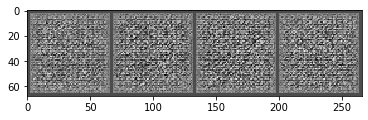

Epoch: 0, Discriminator Loss: 3.7671, Generator Loss: 45.8085, AvgDiscriminator Loss: 4.0808, AvgGenerator Loss: 52.5036:  52%|█████▏    | 100/191 [01:21<01:07,  1.34it/s]

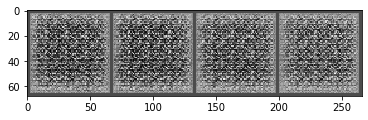

  0%|          | 0/191 [00:00<?, ?it/s]

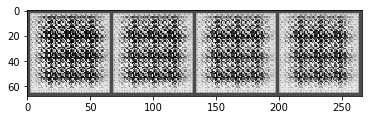

Epoch: 1, Discriminator Loss: 1.0619, Generator Loss: 2.3966, AvgDiscriminator Loss: 3.6601, AvgGenerator Loss: 35.1012:  52%|█████▏    | 100/191 [01:21<01:07,  1.34it/s]

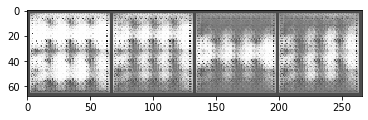

  0%|          | 0/191 [00:00<?, ?it/s]

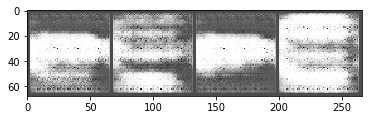

Epoch: 2, Discriminator Loss: 0.4912, Generator Loss: 1.3009, AvgDiscriminator Loss: 2.4938, AvgGenerator Loss: 21.7815:  52%|█████▏    | 100/191 [01:21<01:07,  1.35it/s]

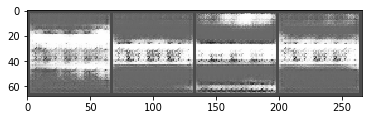

  0%|          | 0/191 [00:00<?, ?it/s]

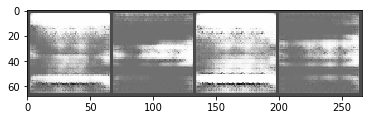

Epoch: 3, Discriminator Loss: 0.4316, Generator Loss: 1.3611, AvgDiscriminator Loss: 1.9582, AvgGenerator Loss: 16.0686:  52%|█████▏    | 100/191 [01:21<01:07,  1.34it/s]

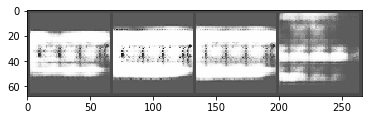

  0%|          | 0/191 [00:00<?, ?it/s]

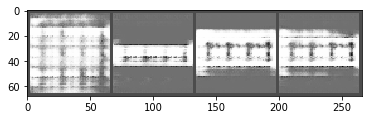

Epoch: 4, Discriminator Loss: 0.4593, Generator Loss: 1.6259, AvgDiscriminator Loss: 1.6508, AvgGenerator Loss: 12.8931:  52%|█████▏    | 100/191 [01:21<01:07,  1.34it/s]

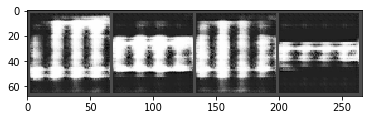

  0%|          | 0/191 [00:00<?, ?it/s]

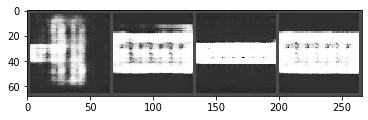

Epoch: 5, Discriminator Loss: 0.4929, Generator Loss: 1.0377, AvgDiscriminator Loss: 1.4596, AvgGenerator Loss: 10.8765:  52%|█████▏    | 100/191 [01:21<01:08,  1.34it/s]

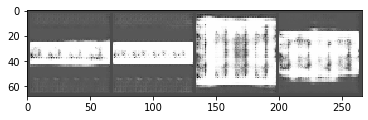

  0%|          | 0/191 [00:00<?, ?it/s]

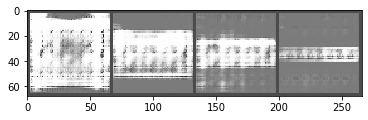

Epoch: 6, Discriminator Loss: 0.7349, Generator Loss: 3.7460, AvgDiscriminator Loss: 1.3192, AvgGenerator Loss: 9.4840:  52%|█████▏    | 100/191 [01:21<01:07,  1.35it/s]

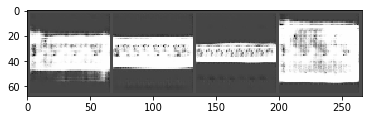

  0%|          | 0/191 [00:00<?, ?it/s]

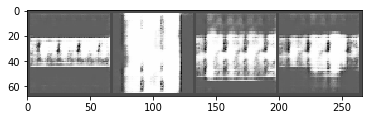

Epoch: 7, Discriminator Loss: 0.4028, Generator Loss: 1.2822, AvgDiscriminator Loss: 1.2194, AvgGenerator Loss: 8.4570:  52%|█████▏    | 100/191 [01:21<01:07,  1.35it/s]

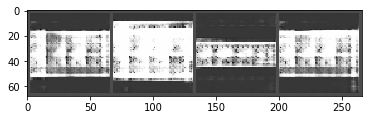

Epoch: 7, Discriminator Loss: 0.4990, Generator Loss: 2.0834, AvgDiscriminator Loss: 1.2022, AvgGenerator Loss: 8.2999:  71%|███████   | 135/191 [01:51<00:46,  1.20it/s]

In [0]:
try:
  generator, d_losses, g_losses = train()
except:
  __ITB__()
  gc.collect()

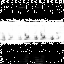

In [271]:
img = generator(torch.randn(1, 100, 1, 1).cuda()).squeeze(0).cpu()
tensor_to_image(img)